# Bubble Detection using LPPL Model and Parameter Estimation with Bayesian + MCMC

## Project Overview

This project aims to detect **financial market bubbles** and predict potential **crash points** using the **Log-Periodic Power Law (LPPL)** model.  
Additionally, we apply **Bayesian inference combined with MCMC (Markov Chain Monte Carlo)** to estimate the **uncertainty in LPPL model parameters**.

The LPPL model is mathematically designed to capture **nonlinear acceleration and log-periodic oscillations** that typically appear before market crashes:

$$
\ln P(t) = A + B (t_c - t)^m + C (t_c - t)^m \cos \left( \omega \ln(t_c - t) + \phi \right)
$$

Where:

- $t_c$: the predicted **critical time (crash point)**
- $(t_c - t)^m$: represents the **nonlinear power-law trend** (accelerating growth)
- $\cos(\omega \ln(t_c - t) + \phi)$: captures **log-periodic oscillations** that intensify as $t \rightarrow t_c$

## Objectives

- Detect speculative bubbles in **NASDAQ (IXIC)** using the LPPL model
- Fit and visualize LPPL using the `lppls` Python library
- Extend to Bayesian inference using MCMC to estimate **credible intervals for $t_c$**

## Tools Used

- Python 3.x
- `yfinance`, `lppls`, `pymc`, `arviz`, `scipy.stats`, `matplotlib`, `numpy`, `pandas`, `seaborn`
- Jupyter Notebook / Visual Studio Code

## Future Plans

- Implement **posterior estimation** using PyMC or Stan
- Visualize **crash probability** based on posterior distribution of $t_c$
- Conduct **sliding-window LPPL fitting** and compute bubble confidence metrics

<hr>

# Structure of the LPPL Model and Parameter Estimation Strategy

## LPPLS Library Internal Workflow

To find the best-fitting parameter set, the LPPLS model uses **random initialization** of nonlinear parameters and then searches for the nearest **local minimum** by minimizing the error (SSE). This process yields a **single deterministic estimate**, but:

> **Limitations**:  
> - The result contains no information about uncertainty.  
> - Different random initializations can lead to different outcomes, making the process **non-reproducible** and **unstable**.

### Key Functional Flow

1. **`fit()`**  
   - Randomly initialize nonlinear parameters: $(t_c, m, w)$  
   - Use `scipy.optimize.minimize` to minimize the objective function  
   - Estimate linear parameters $(A, B, C_1, C_2)$ via a closed-form solution using `matrix_equation()`  
   - If optimization fails to converge, retry with new seeds up to `max_searches`

2. **`lppls()`**  
   - The original cosine term is rewritten into a linear combination of cosine and sine:
     $$
     C \cdot \cos(\omega \ln(t_c - t) + \phi) = C_1 \cos(\omega \ln(t_c - t)) + C_2 \sin(\omega \ln(t_c - t))
     $$
     where:
     $$
     C_1 = C \cos(\phi), \quad C_2 = -C \sin(\phi)
     $$
   - This transformation improves **fitting stability** by:
     - Reducing the number of nonlinear parameters (eliminating $\phi$ from direct optimization)
     - Converting to a linear-in-parameters form for OLS
     - Preventing instability and slow convergence due to dimensionality and multiple local minima

## Mathematical Optimization: How Parameters Are Estimated

### 1. Objective Function
The model minimizes the sum of squared errors (SSE) between observed and predicted log prices:

$$
\min_{t_c, m, w, A, B, C_1, C_2} \sum_{i=1}^{N} \left( \ln P_i^{obs} - \ln P_i^{model} \right)^2
$$

### 2. Optimization Strategy
- Nonlinear parameters $(t_c, m, w)$ are searched via random initialization + local optimization  
- Linear parameters $(A, B, C_1, C_2)$ are computed using the `matrix_equation()` closed-form OLS  
- The process is repeated (up to `max_searches`) to avoid convergence to poor local minima

## Interpretation of Parameters and Their Constraints

| Parameter | Meaning | Interpretation |
|----------|---------|----------------|
| $t_c$    | Critical Time | Predicted timing of the crash |
| $m$      | Growth Rate (0 < m < 1) | Power-law acceleration rate; lower $m$ implies sharper growth |
| $w$      | Frequency (6 < w < 13) | Frequency of log-periodic oscillations |
| $A$      | Intercept of $\ln P(t)$ | Baseline log-price level |
| $B$      | Power-law coefficient | If $B < 0$: upward bubble formation; $B > 0$: downward bubble |
| $C_1$, $C_2$ | Oscillatory coefficients | Linear decomposition of log-periodic wave |
| $O$      | Oscillation Count | Number of visible oscillation cycles (≥2 implies bubble validity) |
| $D$      | Damping Factor | Strength of oscillation damping; too low implies instability |

[*********************100%***********************]  1 of 1 completed

Critical time (Crash point): 2025-11-02
TC Search Range: 2025-05-15 ~ 2025-08-14


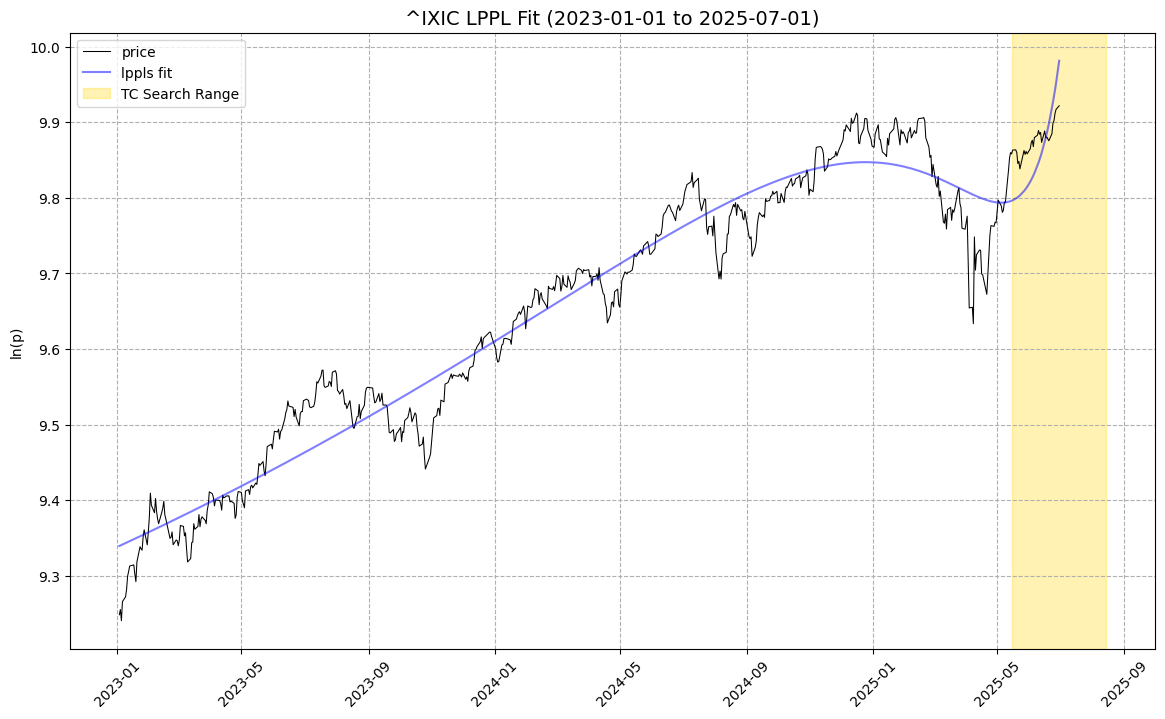

In [50]:
from lppls import lppls  
import numpy as np       
import pandas as pd     
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt

# Set the ticker symbol and date range
ticker = '^IXIC'  # NASDAQ Composite Index
start_date = '2023-01-01'
end_date = '2025-07-01'

# Download historical data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

# Ensure the DataFrame has the necessary columns
data.reset_index(inplace=True)
data = data[['Date', 'Close']]

# Convert 'Date' to ordinal numbers
time = data['Date'].apply(pd.Timestamp.toordinal).values  

# Take the natural logarithm of the 'Close' prices
price = np.log(data['Close']).values.reshape(-1) 

# Create a 2xN array of [time, log_price] to be used in the LPPL model
observations = np.array([time, price]) 

# Set the maximum number of random fitting attempts
MAX_SEARCHES = 25 

# Instantiate the LPPLS model with observation data
lppls_model = lppls.LPPLS(observations=observations)  

# Fit the model with MAX_SEARCHES attempts; extract the parameters
results = lppls_model.fit(MAX_SEARCHES)
tc, m, w, a, b, c, c1, c2, O, D = results
tc_date = datetime.fromordinal(int(tc))     # Extract the estimated critical time

# Compute the search range for tc (critical time) based on a ±5% buffer around the data range 
t1 = observations[0, 0]
t2 = observations[0, -1]
time_delta = t2 - t1     

# Total duration of the time series
tc_range_min_ord = t2 - 0.05 * time_delta
tc_range_max_ord = t2 + 0.05 * time_delta

# Convert ordinal values back to datetime for display/plotting
tc_range_min_date = datetime.fromordinal(int(tc_range_min_ord))
tc_range_max_date = datetime.fromordinal(int(tc_range_max_ord))

# Print the predicted crash point and the search range used
print(f"Critical time (Crash point): {tc_date.strftime('%Y-%m-%d')}")
print(f"TC Search Range: {tc_range_min_date.strftime('%Y-%m-%d')} ~ {tc_range_max_date.strftime('%Y-%m-%d')}")

# Plot the LPPL fit over the observed data
lppls_model.plot_fit()
ax = plt.gca()
ax.axvspan(tc_range_min_date, tc_range_max_date, color='gold', alpha=0.3, label='TC Search Range')
ax.legend()

# Add a plot title summarizing the ticker and time period
plt.title(f'{ticker} LPPL Fit ({start_date} to {end_date})', fontsize=14)
plt.show()


## Limitations of the Traditional LPPL Model

The Log-Periodic Power Law (LPPL) model, developed by Sornette and colleagues, has been widely recognized as a powerful tool for detecting financial market bubbles and forecasting critical crash points.  
However, the model has the following **fundamental limitations**:

- **Nonlinearity Issues**:  
  The LPPL equation is a highly nonlinear function involving more than 7 parameters,  
  making it prone to local minima and sensitive to initial conditions.

- **Unstable Parameter Estimation**:  
  Traditional fitting methods such as Nonlinear Least Squares (NLS) exhibit high sensitivity to data changes,  
  resulting in significantly **unstable parameter estimates** even with minor variations in the input data.

- **Low Predictive Reliability**:  
  The predicted crash time $t_c$ often varies greatly across fitting attempts,  
  making it difficult to draw reliable conclusions from the results.


## Motivation for Bayesian + MCMC Approach

To address these challenges, we adopt a probabilistic approach using the **Bayesian inference framework** combined with **Markov Chain Monte Carlo (MCMC)** simulation.

- **Core Idea**:  
  Instead of finding a single "optimal" parameter value,  
  we aim to **explore the full probability distribution** over all plausible parameter combinations.

- **Key Advantage**:  
  This approach allows us to rigorously account for parameter uncertainty,  
  producing more robust and statistically grounded predictions compared to conventional methods.

<hr>

# Bayesian Inference + MCMC-Based LPPLS Parameter Estimation

## Motivation and Rationale

The LPPL (Log-Periodic Power Law) model is a powerful nonlinear regression model designed to predict financial bubbles and their potential collapse times.  
However, traditional LPPL fitting methods rely on single-point optimization, which suffers from:

- High instability due to many local minima
- Sensitivity to initial values and randomness
- Lack of uncertainty quantification (no confidence intervals)

To overcome these limitations, we adopt a **Bayesian framework with MCMC sampling**,  
allowing us to infer **posterior distributions of the parameters**, especially the critical time $t_c$,  
with **credible intervals** and robust uncertainty analysis.

## Overview of the Bayesian Modeling Process

Bayesian estimation involves the following components:

### 1. Prior $P(\theta)$

- Represents prior beliefs about the possible values of the parameters
- Example settings:
  - $ t_c \sim \text{Uniform}(t_{\text{end}},\ t_{\text{end}} + 100) $
  - $ m \sim \text{Uniform}(0.1,\ 1.0) $
  - $ w \sim \text{Uniform}(4,\ 13) $
  - $ A, B, c_1, c_2 \sim \mathcal{N}(0,\ 1) $
  - $ \sigma \sim \text{HalfNormal}(0.1) $

### 2. Likelihood $P(Q \mid \theta)$

- The likelihood of observing data $Q$ given the parameters $\theta$
- Assumes normally distributed errors around model predictions
- Equation:
  $$
  \ln P(t) = A + B(tc - t)^m + (tc - t)^m \cdot \left[ c_1 \cos(w \ln(tc - t)) + c_2 \sin(w \ln(tc - t)) \right]
  $$
  $$
  y_t \sim \mathcal{N}(\mu(t; \theta), \sigma^2)
  $$

### 3. Posterior $P(\theta \mid Q)$

- Updated distribution of parameters given observed data
- Computed as:
  $$
  P(\theta \mid Q) \propto P(Q \mid \theta) \cdot P(\theta)
  $$

### 4. MCMC Sampling

- Since the posterior is not analytically solvable, we use MCMC (Markov Chain Monte Carlo) to approximate it
- Sampling is performed using the NUTS (No-U-Turn Sampler) algorithm via `PyMC`
- Thousands of samples are drawn across multiple chains for convergence and robustness

## Parameter Modeling Intuition

The parameters are modeled to reflect meaningful properties of the bubble process:

| Parameter | Meaning | Prior Design |
|-----------|---------|--------------|
| $t_c$ | Critical time of bubble collapse | Uniform over future range |
| $m$   | Acceleration exponent | Uniform between (0.1, 1.0) |
| $w$   | Log-periodic frequency | Literature-based range (4 to 13) |
| $A$   | Baseline log price | Normal around observed log prices |
| $B$   | Power-law growth strength | Zero-centered Normal |
| $C_1$, $C_2$ | Oscillation coefficients | For cosine/sine decomposition |
| $sigma$ | Observation noise | HalfNormal to enforce positivity |

## Posterior Analysis & Visualization

- After MCMC sampling, $t_c$ posterior samples are flattened and analyzed (Shows the most likely collapse date with a mode line)
- **KDE (Kernel Density Estimation)**: Smooth estimation of the posterior probability density (Highlight smooth density and peak (mode))
- **Histogram**: Discrete representation of posterior frequency (Show sample frequency structure)
- **94% HDI (Highest Density Interval)**: The most credible range containing 94% of posterior mass (Shows credible interval width and location)
- **Seaborn Visualization** provides intuitive understanding:

## Advantages of This Approach

- Provides **full distribution** instead of a single estimate
- Enables **quantification of uncertainty** (e.g., confidence intervals, tail behavior)
- Improves **reproducibility** and **robustness** compared to traditional optimization
- Enhances real-world applicability for **risk management** and **hedging strategies**

## Summary

- The Bayesian LPPL + MCMC approach consistently yields stable probability distributions even under complex market structures, making it a powerful alternative that simultaneously addresses parameter uncertainty and bubble timing prediction.

- The final output includes the seaborn-based plot of the posterior distribution along with the most probable predicted date (Mode) and the 94% Highest Density Interval (HDI).
This method demonstrates high reliability, as it shows:
  - Zero divergences during sampling
  -	All R-hat values converging to 1.0 across parameters
  -	Sufficient effective sample size (ESS)
  
  These diagnostics indicate that the posterior inference is both stable and trustworthy.


In [88]:
import pymc as pm
import numpy as np
import pandas as pd
import yfinance as yf
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import gaussian_kde

def time_price_data(ticker_symbol, year_period = 2):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365 * year_period)
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    data.reset_index(inplace=True)
    data = data[['Date', 'Close']].dropna()
    time_data = data['Date'].apply(pd.Timestamp.toordinal).values

    # Take natural log of prices 
    log_price_data = np.log(data['Close'].values)

    return time_data, log_price_data

def lppl_mcmc(time_data, log_price_data):
    # PyMC Modeling (Reparameterized LPPL)
    with pm.Model() as lppl_model:
        t_end = time_data[-1]   # Last time in the dataset
        tc = pm.Uniform('tc', lower=t_end, upper=t_end + 100, initval=t_end + 50)   # Critical time
        m = pm.Uniform('m', lower=0.1, upper=1.0)   # Exponent for power-law
        w = pm.Uniform('w', lower=4.0, upper=13.0)  # Log-periodic frequency
        A = pm.Normal('A', mu=log_price_data.mean(), sigma=log_price_data.std())    # Baseline level
        B = pm.Normal('B', mu=0, sigma=1)       # Amplitude of power-law component
        c1 = pm.Normal('c1', mu=0, sigma=1)     # Cosine term coefficient
        c2 = pm.Normal('c2', mu=0, sigma=1)     # Sine term coefficient
        sigma = pm.HalfNormal('sigma', sigma=0.1)   # Observation noise

        # Define Expected Value
        dt = tc - time_data      # Time to critical point
        log_dt = pm.math.log(dt)
        oscillation = c1 * pm.math.cos(w * log_dt) + c2 * pm.math.sin(w * log_dt)       # Log-periodic oscillation
        expected_log_price = A + B * (dt**m) + (dt**m) * oscillation        # Full LPPL expression

        # Likelihood: observed log prices follow Normal distribution around model prediction
        pm.Normal('Y_obs', mu=expected_log_price, sigma=sigma, observed=log_price_data)

        trace = pm.sample(
            draws=4000,     # Posterior samples to draw
            tune=2000, 
            target_accept=0.99,     # High target_accept for better stability
            control={'max_treedepth': 15},      # Increase max tree depth for complex posterior geometries
            chains=4,       # Run 4 independent MCMC chains to assess convergence (e.g., via R-hat diagnostics)
            cores=4,        # Use 4 CPU cores to run the chains in parallel for faster sampling
            progressbar=True
        )

    return trace

def summarize_posterior(trace):
    # Summarize posterior samples of tc
    summary = az.summary(trace, var_names=['tc'])
    tc_samples = trace.posterior['tc'].values.flatten()

    # Kernel Density Estimation on tc
    kde = gaussian_kde(tc_samples)
    x_grid = np.linspace(tc_samples.min(), tc_samples.max(), 1000)

    # Mode (most probable tc)
    mode_ordinal = x_grid[np.argmax(kde.evaluate(x_grid))]
    mode_date = datetime.fromordinal(int(mode_ordinal))

    # Extract 94% HDI (highest density interval) bounds for tc
    hdi_3_date = datetime.fromordinal(int(summary.loc['tc', 'hdi_3%']))
    hdi_97_date = datetime.fromordinal(int(summary.loc['tc', 'hdi_97%']))

    return tc_samples, mode_date, hdi_3_date, hdi_97_date


def plot_posterior_tc(tc_samples, mode_date, hdi_3_date, hdi_97_date, ticker_symbol):
    # Plotting Posterior Distribution
    tc_dates = [datetime.fromordinal(int(val)) for val in tc_samples]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot histogram and KDE using seaborn
    sns.histplot(x=tc_dates, ax=ax, bins=50, kde=True, stat="density")

    # Draw HDI interval as a thick black line
    y_pos = ax.get_ylim()[1] * 0.05
    ax.plot([hdi_3_date, hdi_97_date], [y_pos, y_pos], lw=4, color='black', label='94% HDI')
    ax.text(mode_date, y_pos, '94% HDI', ha='center', va='bottom', fontsize=12)
    
    # Add a vertical line at the mode of the distribution
    ax.axvline(mode_date, color='red', linestyle='--', label=f'Mode: {mode_date.strftime("%Y-%m-%d")}')

    # Set plot labels and title
    ax.set_title(f'Posterior Distribution of Critical Time ({ticker_symbol})', fontsize=16)
    ax.set_xlabel('Predicted Critical Time (tc)', fontsize=12)
    ax.set_ylabel('Probability Density', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    # Rotate date labels for clarity
    fig.autofmt_xdate()
    plt.show()

def bayesian_mcmc_simulation(ticker_symbol, year_period = 2):
    time_data, log_price_data = time_price_data(ticker_symbol, year_period = year_period)
    trace = lppl_mcmc(time_data, log_price_data)
    tc_samples, mode_date, hdi_3_date, hdi_97_date = summarize_posterior(trace)

    print(f"Most Probable Date (Mode): {mode_date.strftime('%Y-%m-%d')}")
    print(f"94% HDI: {hdi_3_date.strftime('%Y-%m-%d')} ~ {hdi_97_date.strftime('%Y-%m-%d')}")

    plot_posterior_tc(tc_samples, mode_date, hdi_3_date, hdi_97_date, ticker_symbol)


[*********************100%***********************]  1 of 1 completed
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tc, m, w, A, B, c1, c2, sigma]


/Users/nahyunlee/Quant_LLM_Trading/venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 1078 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.


Most Probable Date (Mode): 2025-09-30
94% HDI: 2025-07-28 ~ 2025-10-28


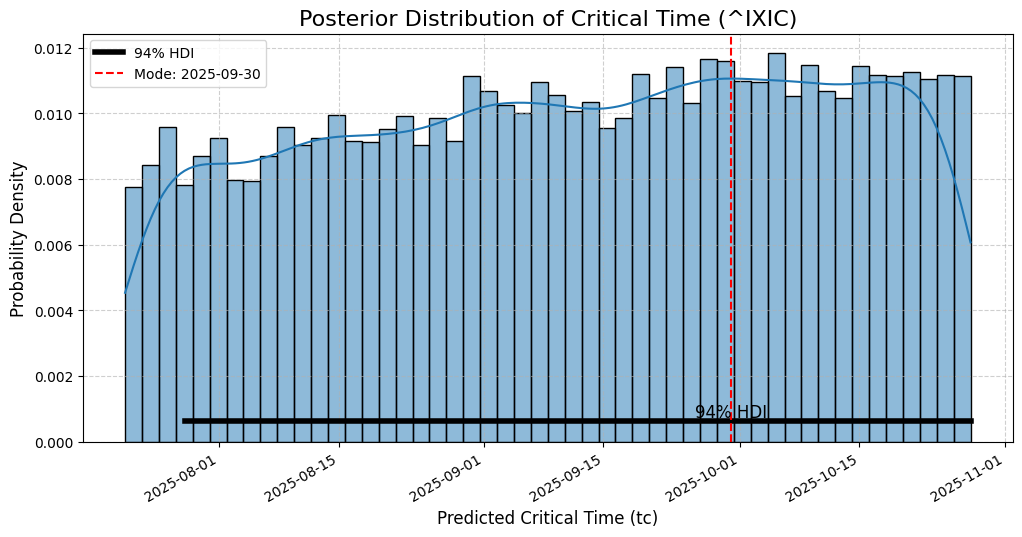

In [ ]:
bayesian_mcmc_simulation('^IXIC') # Nasdaq